#**PSD UTS "Prediksi Produksi Penjualan Ice Cream"**



*   Nama : Zulfa Lailatul Mu'achirin
*   Nim : 220411100147
*   Matkul : PSD D

## Data Understanding

Data diperoleh dari kaggle https://www.kaggle.com/datasets/atharvaarya25/ice-cream-production-over-50-years. Pada data tersebut hanya terdapat 2 fitur yaitu DATE yang menunjukkan tanggal dan IPN31152N yang merupakan fitur produksi penjualan. Pada data ini terdapat 577 data yang dikumpulkan dari 48 tahun terakhir mulai dari tahun 1972 sampai tahun 2020. Data yang dikumpulkan merupakan data yang diambil setiap bulan pada tanggal 1 untuk produksi penjualan.

### library

In [34]:
import pandas as pd
import numpy as np
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor # Import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler # Import StandardScaler for scaling
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import VotingRegressor

### menampilkan data

In [22]:
df = pd.read_excel("/content/drive/MyDrive/kuliah sem 5/PSD/Mydata/ice_cream.xlsx")
df['DATE'] = pd.to_datetime(df['DATE'])

# Set DATE as index
df.set_index('DATE', inplace=True)
df

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-09-01,100.1741
2019-10-01,90.1684
2019-11-01,79.7223


## Data Preprocessing

### menambahkan fitur

menambahkan fitur month untuk memberikan perhitungan di setiap bulannya

Untuk menerapkan pembelajaran supervised pada peramalan time series , kita perlu mengubah data time series ke dalam format yang sesuai. Hal ini melibatkan pembuatan pasangan input-output dari data berurutan menggunakan teknik sliding window.

In [23]:
# We'll use a supervised learning approach: predicting the next value based on previous values
df['Month'] = np.arange(1,len(df)+1)  # Adding a month counter
df

,IPN31152N,Month
DATE,,
1972-01-01,59.9622,1
1972-02-01,67.0605,2
1972-03-01,74.2350,3
1972-04-01,78.1120,4
1972-05-01,84.7636,5
...,...,...
2019-09-01,100.1741,573
2019-10-01,90.1684,574
2019-11-01,79.7223,575


### missing value

mengecek apakah ada missing value pada data yang dipakai

In [24]:
missing_values = df.isnull().sum()
print(missing_values)

IPN31152N    0
Month        0
dtype: int64


### deskripsi data

In [25]:
description = df.describe()
print(description)

        IPN31152N       Month
count  577.000000  577.000000
mean   109.701844  289.000000
std     27.951723  166.709828
min     58.659800    1.000000
25%     88.514900  145.000000
50%    107.461700  289.000000
75%    127.932300  433.000000
max    196.173700  577.000000


## Modeling

### membagi data

Untuk fiturnya kita memakai fitur month serta untuk targetnya kita memakai fitur IPN31152N, kemudian dengan teknik sliding window untuk mengenerate fitur berdasarkan bulan sebelumnya. Untuk window_size nya sendiri adalah 12, karena kita akan memakai 12 bulan untuk prediksi 12 bulan kedepan

Metode jendela geser melibatkan penggunaan jendela berukuran tetap dari langkah waktu sebelumnya untuk memprediksi langkah waktu berikutnya. Metode ini juga dikenal sebagai data tertinggal(lagged data).

In [26]:
# Features (Months), Target (IPN31152N)
X = df[['Month']]
y = df['IPN31152N']

# Creating a sliding window function to generate features based on previous months
def create_sliding_window_features(df, window_size):
    X, y = [], []
    for i in range(window_size, len(df)):
        X.append(df[i-window_size:i])
        y.append(df[i])
    return np.array(X), np.array(y)

# Set window size to 12 months (can be adjusted)
window_size = 12

# Creating sliding window features for the target variable
X_window, y_window = create_sliding_window_features(df['IPN31152N'].values, window_size)
print("Shape of X_window:", X_window.shape)
print("Shape of y_window:", y_window.shape)

Shape of X_window: (565, 12)
Shape of y_window: (565,)


Kalau ingin dilihat hasil dari X_window dan y_window

In [27]:
# Membuat dataframe
columns = [f'Month-{i}' for i in range(window_size, 0, -1)]  # Nama kolom untuk 12 bulan sebelumnya
df_window = pd.DataFrame(X_window, columns=columns)  # Data 12 bulan sebelumnya
df_window['Target'] = y_window  # Kolom target

# Menampilkan dataframe
df_window

,Month-12,Month-11,Month-10,Month-9,Month-8,Month-7,Month-6,Month-5,Month-4,Month-3,Month-2,Month-1,Target
0,59.9622,67.0605,74.2350,78.1120,84.7636,100.5960,100.1263,96.3607,85.8007,70.3934,60.8072,58.6598,61.0996
1,67.0605,74.2350,78.1120,84.7636,100.5960,100.1263,96.3607,85.8007,70.3934,60.8072,58.6598,61.0996,72.2062
2,74.2350,78.1120,84.7636,100.5960,100.1263,96.3607,85.8007,70.3934,60.8072,58.6598,61.0996,72.2062,80.0984
3,78.1120,84.7636,100.5960,100.1263,96.3607,85.8007,70.3934,60.8072,58.6598,61.0996,72.2062,80.0984,83.9059
4,84.7636,100.5960,100.1263,96.3607,85.8007,70.3934,60.8072,58.6598,61.0996,72.2062,80.0984,83.9059,87.3712
...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,103.3118,92.1321,82.4347,76.7608,86.9988,98.1116,116.1718,114.9703,114.5613,124.9605,110.2632,102.6085,100.1741
561,92.1321,82.4347,76.7608,86.9988,98.1116,116.1718,114.9703,114.5613,124.9605,110.2632,102.6085,100.1741,90.1684
562,82.4347,76.7608,86.9988,98.1116,116.1718,114.9703,114.5613,124.9605,110.2632,102.6085,100.1741,90.1684,79.7223
563,76.7608,86.9988,98.1116,116.1718,114.9703,114.5613,124.9605,110.2632,102.6085,100.1741,90.1684,79.7223,75.7094


dari array hasil pada pembuatan fitur dengan sliding window kita akan membagi datanya untuk dijadikan data train dan data test. Dengan data train 80% dan data test 20% tanpa diacak, guna mempertahankan urutan waktunya. Kemudian kita normalisasi dengan standarscaler.

Kode ini digunakan untuk melakukan standarisasi pada fitur-fitur di dataset X_train_w dan X_test_w sebelum diterapkan ke model machine learning. Standarisasi adalah teknik transformasi data yang mengubah distribusi fitur-fitur sehingga memiliki mean 0 dan standard deviation 1.

In [28]:
# Splitting the df into training and test sets
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_window, y_window, test_size=0.2, shuffle=False)

# Scaling features
scaler = StandardScaler()
X_train_w_scaled = scaler.fit_transform(X_train_w)
X_test_w_scaled = scaler.transform(X_test_w)

### membuat model

untuk modeling dengan bagging regressor kita akan menggunakan 3 base model. Dari 3 model tersebut akan menghasilkan masing masing prediksi, kemudian prediksi-prediksi tersebut akan di ambil rata-ratanya dengan menggunakan voting regressor. Voting regressor inilah yang akan digunakan untuk inputan meta predictor bagging. Setelah dilakukan prediksi akan dihitung juga rmse, mse, mae, dan r2 nya. Prediksi 12 bulan kedepan menggunakan teknik sliding window dengan mengisi nilai pada bulan selanjutnya dengan prediksi baru

#### Bagging

In [29]:
# Define the three base models
tree_model = DecisionTreeRegressor()
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
linear_model = LinearRegression()

# Create a VotingRegressor (acts as the combination of 3 base models)
voting_regressor = VotingRegressor(estimators=[('tree', tree_model), ('forest', forest_model), ('linear', linear_model)])

# Build the Bagging Regressor with the VotingRegressor as the base model
bagging_model_voting = BaggingRegressor(estimator=voting_regressor, n_estimators=100, random_state=42)
bagging_model_voting.fit(X_train_w_scaled, y_train_w)

# Predicting on the test set
y_pred_voting = bagging_model_voting.predict(X_test_w_scaled)

# Calculate performance metrics
rmse_voting = np.sqrt(mean_squared_error(y_test_w, y_pred_voting))
mse_voting = mean_squared_error(y_test_w, y_pred_voting)
mae_voting = mean_absolute_error(y_test_w, y_pred_voting)
r2_voting = r2_score(y_test_w, y_pred_voting)

# Predicting the next 12 months using the ensemble sliding window
last_window = df['IPN31152N'].values[-window_size:]
predictions_voting = []
for _ in range(12):
    last_window_scaled = scaler.transform(last_window.reshape(1, -1))
    next_pred = bagging_model_voting.predict(last_window_scaled)
    predictions_voting.append(next_pred[0])
    # Update the window with the new prediction
    last_window = np.append(last_window[1:], next_pred)



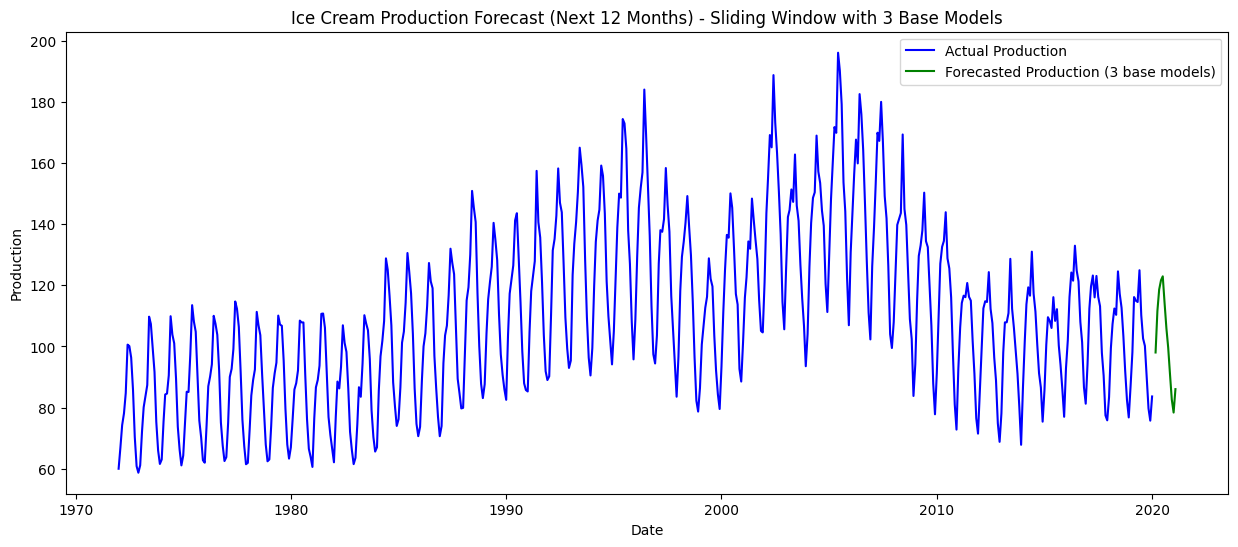

RMSE: 6.196240727928091
MSE: 38.39339915843484
MAE: 5.089241808279032
R^2 Score: 0.8493111713673671


In [30]:
# Plotting the actual vs predicted values with the sliding window approach (3 base models)
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['IPN31152N'], label='Actual Production', color='blue')
plt.plot(pd.date_range(start=df.index[-1], periods=13, freq='ME')[1:], predictions_voting, label='Forecasted Production (3 base models)', color='green')
plt.title('Ice Cream Production Forecast (Next 12 Months) - Sliding Window with 3 Base Models')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

# rmse_voting, mse_voting, mae_voting, r2_voting, predictions_voting
print("RMSE:", rmse_voting)
print("MSE:", mse_voting)
print("MAE:", mae_voting)
print("R^2 Score:", r2_voting)

In [31]:
# Ambil tanggal terakhir dari index 'DATE'
last_date = df.index[-1]  # Ini ambil tanggal dari index

# Buat list tanggal untuk 12 bulan ke depan
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')  # 'MS' = Mulai dari awal bulan

# Membuat DataFrame untuk hasil prediksi dengan tanggal
df_predictions = pd.DataFrame({
    'Date': future_dates,
    'Predicted Value': predictions_voting
})

# Menampilkan DataFrame prediksi dengan tanggal
df_predictions


,Date,Predicted Value
0,2020-02-01,98.022136
1,2020-03-01,111.621013
2,2020-04-01,118.646867
3,2020-05-01,121.675161
4,2020-06-01,122.966134
5,2020-07-01,114.166667
6,2020-08-01,105.908311
7,2020-09-01,99.619897
8,2020-10-01,90.810461
9,2020-11-01,82.629228


#### Arima

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


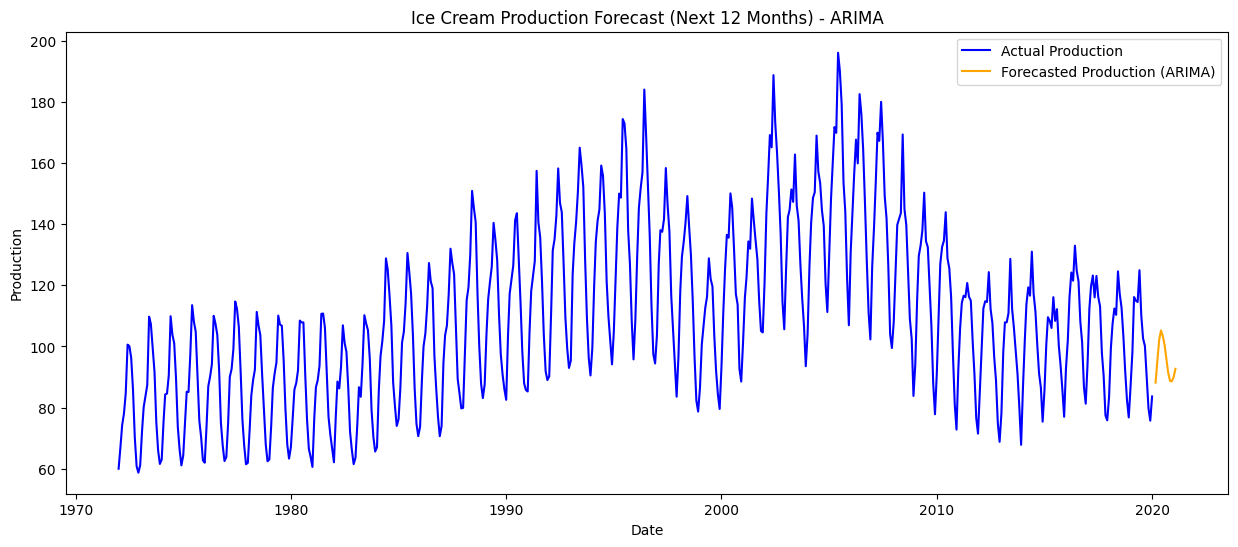

ARIMA Metrics:
RMSE: 12.333444832552512
MSE: 152.11386143761626
MAE: 11.09693695593728
R^2 Score: 0.3462485919636229


In [32]:
# Fit ARIMA model
model_arima = ARIMA(df['IPN31152N'], order=(5, 1, 0))  # Sesuaikan order (p, d, q)
model_arima_fit = model_arima.fit()

# Forecast untuk 12 bulan ke depan
forecast_arima = model_arima_fit.forecast(steps=12)

# Hitung metrik untuk ARIMA
y_test_arima = df['IPN31152N'].values[-12:]  # Ambil data aktual untuk 12 bulan terakhir
rmse_arima = np.sqrt(mean_squared_error(y_test_arima, forecast_arima))
mse_arima = mean_squared_error(y_test_arima, forecast_arima)
mae_arima = mean_absolute_error(y_test_arima, forecast_arima)
r2_arima = r2_score(y_test_arima, forecast_arima)

# Plotting hasil prediksi ARIMA
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['IPN31152N'], label='Actual Production', color='blue')
plt.plot(pd.date_range(start=df.index[-1], periods=13, freq='ME')[1:], forecast_arima, label='Forecasted Production (ARIMA)', color='orange')
plt.title('Ice Cream Production Forecast (Next 12 Months) - ARIMA')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

# Print metrik ARIMA
print("ARIMA Metrics:")
print("RMSE:", rmse_arima)
print("MSE:", mse_arima)
print("MAE:", mae_arima)
print("R^2 Score:", r2_arima)


#### Linier Regression

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


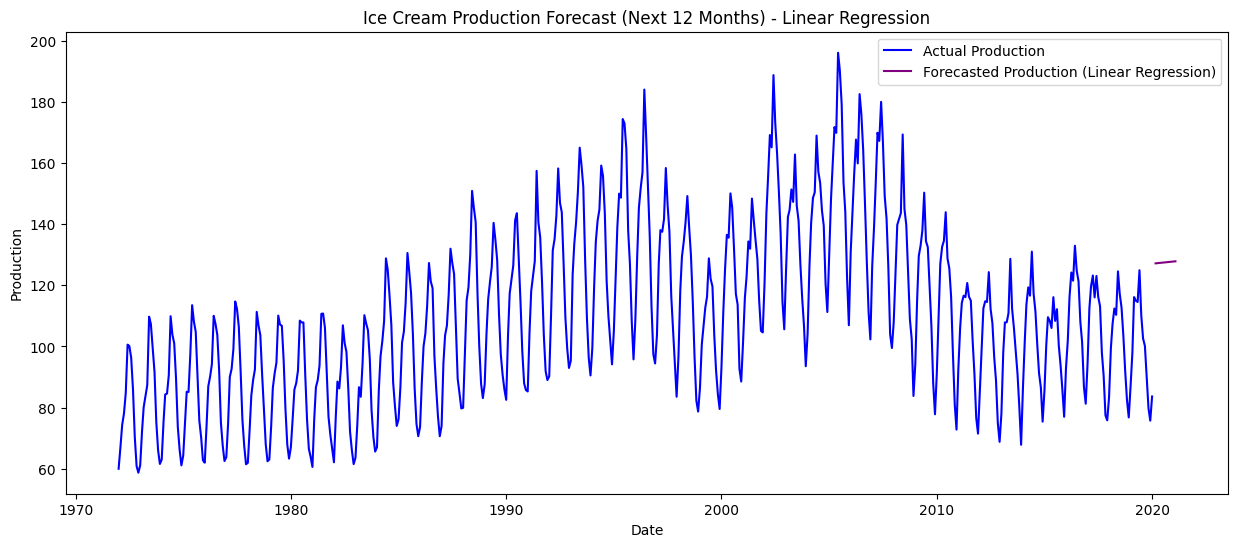

Linear Regression Metrics:
RMSE: 30.76593791572399
MSE: 946.5429358341829
MAE: 26.62520963498095
R^2 Score: -3.0680301664832967


In [33]:
# Membuat fitur bulan dari data
df['Month_Num'] = range(1, len(df) + 1)

# Fit Linear Regression model
lin_reg_model = LinearRegression()
lin_reg_model.fit(df[['Month_Num']], df['IPN31152N'])

# Prediksi 12 bulan ke depan
future_months = np.array(range(len(df) + 1, len(df) + 13)).reshape(-1, 1)
forecast_lin_reg = lin_reg_model.predict(future_months)

# Hitung metrik untuk Linear Regression
y_test_lin_reg = df['IPN31152N'].values[-12:]  # Ambil data aktual untuk 12 bulan terakhir
rmse_lin_reg = np.sqrt(mean_squared_error(y_test_lin_reg, forecast_lin_reg))
mse_lin_reg = mean_squared_error(y_test_lin_reg, forecast_lin_reg)
mae_lin_reg = mean_absolute_error(y_test_lin_reg, forecast_lin_reg)
r2_lin_reg = r2_score(y_test_lin_reg, forecast_lin_reg)

# Plotting hasil prediksi Linear Regression
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['IPN31152N'], label='Actual Production', color='blue')
plt.plot(pd.date_range(start=df.index[-1], periods=13, freq='ME')[1:], forecast_lin_reg, label='Forecasted Production (Linear Regression)', color='purple')
plt.title('Ice Cream Production Forecast (Next 12 Months) - Linear Regression')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

# Print metrik Linear Regression
print("Linear Regression Metrics:")
print("RMSE:", rmse_lin_reg)
print("MSE:", mse_lin_reg)
print("MAE:", mae_lin_reg)
print("R^2 Score:", r2_lin_reg)
